In [1]:
from pymongo import MongoClient
import pendulum
import pandas as pd

In [2]:
import altair as alt

In [3]:
client = MongoClient()

In [4]:
db = client['games_report']

In [ ]:
class GameStats:
    
    def __init__(self, game_id):
        self.game_id = game_id
        self.games = db.games
    
    
    
        
    

In [5]:
cur = db.games.aggregate([
    {'$match': {'events': True}},
    {'$limit': 1},
    
    {'$project': {'teams': '$result.team'}},
    {'$project': {'box': 0, 'result': 0}},

    {'$lookup': {
        'from': 'events',
        'let': {'game': '$_id', 'teams': '$teams'},
        'pipeline': [
            {'$match': {'$expr': {'$eq': ['$$game', '$game']}}},
            {'$sort': {'seconds': 1, '_id': 1}},
            {'$unwind': '$events'},
            {'$match': {'$expr': {'$in': ['$team', '$$teams']}}},
            {'$addFields': {'rival': {
                '$arrayElemAt': [{'$filter': {'input': '$$teams', 'as': 'input', 'cond': {'$ne': ['$team', '$$input']}}}, 0]}}},
            
            {'$addFields': {'events.possession': {'$switch': {
                'branches': [
                    {'case': {'$eq': ['$events.type', 'possession']}, 'then': [{'type': 'gain', 'by': '$team'}]},
                    {'case': {'$eq': ['$events.type', '失誤']}, 'then': [{'type': 'loss', 'by': '$team'}, {'type': 'gain', 'by': '$rival'}]},
                    {'case': {'$eq': ['$events.reb_type', '防守籃板']}, 'then': [{'type': 'loss', 'by': '$rival'}, {'type': 'gain', 'by': '$team'}]},
                    {'case': {'$and': [
                        {'$eq': ['$events.shot_result', True]},
                        {'$eq': ['$events.type', '投籃']}
                    ]}, 'then': [{'type': 'loss', 'by': '$team'}, {'type': 'gain', 'by': '$rival'}]},
                    {'case': {'$and': [
                        {'$eq': ['$events.shot_result', True]},
                        {'$eq': ['$events.type', '罰球']},
                        {'$eq': ['$events.shot_number', '$events.total_shots']}
                    ]}, 'then': [{'type': 'loss', 'by': '$team'}, {'type': 'gain', 'by': '$rival'}]},
                    
                ],
                'default': None
            }},
                           'events.team': '$team', 'events.seconds': '$seconds'}},
            {'$unwind': '$events.possession'},
            {'$addFields': {'events.possession.event': '$events.type', 'events.possession.seconds': '$seconds'}},
            
            {'$group': {'_id': '$QTR', 'QTR': {'$push': '$events.possession'}}},
            {'$sort': {'_id': 1}},
            {'$addFields': {'QTR': {'$cond': {
                'if': {'$eq': ['$_id', '1']}, 
                'then': '$QTR', 
                'else':{'$let': {
                    'vars': {
                        'seconds': {
                            '$switch': {
                                'branches': [
                                    {'case': {'$eq': ['$_id', '2']}, 'then': 600.0},
                                    {'case': {'$eq': ['$_id', '3']}, 'then': 1200.0},
                                    {'case': {'$eq': ['$_id', '4']}, 'then': 1800.0},
                                    {'case': {'$eq': ['$_id', 'OT']}, 'then': 2400.0},
                                    {'case': {'$eq': ['$_id', 'OT1']}, 'then': 2700.0},
                                    {'case': {'$eq': ['$_id', 'OT2']}, 'then': 3000.0},
                                ],
                                'default': '$QTR'
                            }},
                        'first_event': {'$arrayElemAt': ['$QTR', 0]}
                    },
                    'in': {'$concatArrays': [[{'type': 'gain', 'by': '$$first_event.by', 'seconds': '$$seconds', 'event': 'possession'}] , '$QTR']}
                }}
            }}
                           }},
            {'$unwind': '$QTR'},
            {'$group': {'_id': {'team': '$QTR.by', 'QTR': '$_id'}, 'possession': {'$push': '$QTR'}}},
            {'$sort': {'_id.team': 1, '_id.QTR': 1}},
            {'$addFields': {'possession':  {'$let': {
                'vars': {
                    'current': '$possession',
                    'previous': {'$concatArrays':[[None], '$possession']},
                },
                'in': {'$let': {
                    'vars': {
                        'pair': {'$zip': {'inputs': ['$$current', '$$previous'], 'useLongestLength': True, 'defaults': [None, None]}}
                    },
                    'in': {'$map': {
                        'input': {'$filter': {'input': '$$pair', 'as': 'input', 'cond': {'$let': {
                        'vars': {
                            'end': {'$arrayElemAt': ['$$input', 0]},
                            'start': {'$arrayElemAt': ['$$input', 1]},
                        },
                        'in': {'$and': [
                            {'$eq': ['$$start.type', 'gain']},
                            {'$eq': ['$$start.type', '$$end.type']},
                        ]
                              }
                    }}}},
                        'as': 'pair',
                        'in': {'$let': {
                            'vars': {
                                'end': {'$arrayElemAt': ['$$pair', 0]},
                                'start': {'$arrayElemAt': ['$$pair', 1]},
                            },
                            'in': ['$$start', '$$end']
                        }}
                    }}
                }}
            }}}},
#             {'$addFields': {'possession':  {'$let': {
#                 'vars': {
#                     'current': '$possession',
#                     'previous': {'$concatArrays':[[None], '$possession']},
#                 },
#                 'in': {'$let': {
#                     'vars': {
#                         'pair': {'$zip': {'inputs': ['$$current', '$$previous'], 'useLongestLength': True, 'defaults': [None, None]}}
#                     },
#                     'in': {'$map': {
#                         'input': {'$filter': {'input': '$$pair', 'as': 'input', 'cond': {'$let': {
#                         'vars': {
#                             'end': {'$arrayElemAt': ['$$input', 0]},
#                             'start': {'$arrayElemAt': ['$$input', 1]},
#                         },
#                         'in': {'$and': [
#                             {'$eq': ['$$start.type', 'gain']},
#                             {'$ne': ['$$start.type', '$$end.type']},
#                         ]
#                               }
#                     }}}},
#                         'as': 'pair',
#                         'in': {'$let': {
#                             'vars': {
#                                 'end': {'$arrayElemAt': ['$$pair', 0]},
#                                 'start': {'$arrayElemAt': ['$$pair', 1]},
#                             },
#                             'in': {'$subtract': ['$$end.seconds', '$$start.seconds']}
#                         }}
#                     }}
#                 }}
#             }},
#                            }},
#             {'$addFields': {'possession': '$possession.seconds'}},
                            
                        
#                             {'$let': {
#                 'vars': {
#                     'loss': {'$filter': {'input': '$possession', 'as': 'input', 'cond': {'$eq': ['$$input.type', 'loss']}}},
#                     'gain': {'$filter': {'input': '$possession', 'as': 'input', 'cond': {'$eq': ['$$input.type', 'gain']}}},
#                 },
#                 'in': {'$map': {
#                     'input': {'$zip': {'inputs': ['$$gain', '$$loss']}},
#                     'as': 'pair',
#                     'in': {'$let': {
#                     'vars': {
#                         'first': {'$arrayElemAt': ['$$pair', 0]},
#                         'second': {'$arrayElemAt': ['$$pair', 1]},
#                     },
#                     'in': {'$subtract': ['$$second.seconds', '$$first.seconds']}
#                 }}
#                 }}
#             }}
#             {'$limit': 10}
#             {'$group': {'_id': 'team', 'QTR': {'$push': '$QTR'}}}
        ],
        'as': 'events'
    }},
#     {'$addFields': {'events': '$events.events.possession'}},
    
    
    {'$limit': 10}
    
    
])

In [6]:
list(cur)

[{'_id': '7FCF9D06-1C3E-4BC1-8BDE-1A6DFBF3D81E',
  'teams': ['臺灣大學', '佛光大學'],
  'events': [{'_id': {'team': '佛光大學', 'QTR': '1'},
    'possession': [[{'type': 'gain',
       'by': '佛光大學',
       'event': '失誤',
       'seconds': 209.0},
      {'type': 'gain', 'by': '佛光大學', 'event': '失誤', 'seconds': 235.0}],
     [{'type': 'gain', 'by': '佛光大學', 'event': '投籃', 'seconds': 380.0},
      {'type': 'gain', 'by': '佛光大學', 'event': '失誤', 'seconds': 405.0}]]},
   {'_id': {'team': '佛光大學', 'QTR': '2'},
    'possession': [[{'type': 'gain',
       'by': '佛光大學',
       'event': '投籃',
       'seconds': 823.0},
      {'type': 'gain', 'by': '佛光大學', 'event': '失誤', 'seconds': 850.0}]]},
   {'_id': {'team': '佛光大學', 'QTR': '3'},
    'possession': [[{'type': 'gain',
       'by': '佛光大學',
       'event': '投籃',
       'seconds': 1469.0},
      {'type': 'gain', 'by': '佛光大學', 'event': '籃板', 'seconds': 1469.0}]]},
   {'_id': {'team': '佛光大學', 'QTR': '4'},
    'possession': [[{'type': 'gain',
       'by': '佛光大學',
     

In [252]:
cur = db.games.aggregate([
    {'$match': {'events': True}},
    {'$limit': 1},
    {'$lookup': {
        'from': 'events',
        'localField': '_id',
        'foreignField': 'game',
        'as': 'events'
    }},
    {'$project': {'events': 1}}
])

In [250]:
list(cur)

[{'_id': '7FCF9D06-1C3E-4BC1-8BDE-1A6DFBF3D81E',
  'events': [{'QTR': '1',
    '_id': ObjectId('5c6999816136514ec3868231'),
    'events': [{'team': '佛光大學', 'type': 'possession'}],
    'game': '7FCF9D06-1C3E-4BC1-8BDE-1A6DFBF3D81E',
    'player': nan,
    'seconds': 0.0,
    'team': '佛光大學',
    'time_remain': '10:00.000'},
   {'QTR': '1',
    '_id': ObjectId('5c6999816136514ec3868232'),
    'events': [{'player': '羅培甄',
      'shot_result': False,
      'shot_type': '3分',
      'type': '投籃'}],
    'game': '7FCF9D06-1C3E-4BC1-8BDE-1A6DFBF3D81E',
    'player': '羅培甄',
    'seconds': 9.0,
    'team': '佛光大學',
    'time_remain': '09:51.420'},
   {'QTR': '1',
    '_id': ObjectId('5c6999816136514ec3868233'),
    'events': [{'reb_type': '防守籃板', 'type': '籃板'}],
    'game': '7FCF9D06-1C3E-4BC1-8BDE-1A6DFBF3D81E',
    'player': '許硯筑',
    'seconds': 9.0,
    'team': '臺灣大學',
    'time_remain': '09:51.420'},
   {'QTR': '1',
    '_id': ObjectId('5c6999816136514ec3868234'),
    'events': [{'player': '葉祐

In [245]:
list(cur)

[{'_id': '7FCF9D06-1C3E-4BC1-8BDE-1A6DFBF3D81E',
  'events': [{'QTR': [{'by': '佛光大學',
      'event': 'possession',
      'seconds': 0.0,
      'type': 'gain'},
     {'by': '佛光大學', 'event': '籃板', 'seconds': 9.0, 'type': 'loss'},
     {'by': '臺灣大學', 'event': '籃板', 'seconds': 9.0, 'type': 'gain'},
     {'by': '臺灣大學', 'event': '籃板', 'seconds': 36.0, 'type': 'loss'},
     {'by': '佛光大學', 'event': '籃板', 'seconds': 36.0, 'type': 'gain'},
     {'by': '佛光大學', 'event': '失誤', 'seconds': 57.0, 'type': 'loss'},
     {'by': '臺灣大學', 'event': '失誤', 'seconds': 57.0, 'type': 'gain'},
     {'by': '臺灣大學', 'event': '投籃', 'seconds': 75.0, 'type': 'loss'},
     {'by': '佛光大學', 'event': '投籃', 'seconds': 75.0, 'type': 'gain'},
     {'by': '佛光大學', 'event': '罰球', 'seconds': 86.0, 'type': 'loss'},
     {'by': '臺灣大學', 'event': '罰球', 'seconds': 86.0, 'type': 'gain'},
     {'by': '臺灣大學', 'event': '失誤', 'seconds': 99.0, 'type': 'loss'},
     {'by': '佛光大學', 'event': '失誤', 'seconds': 99.0, 'type': 'gain'},
     {'by': '佛

In [7]:
# valid_games = len(db.games.distinct('_id', {'events': True}))

# batch = []
# init = 0
# while init < valid_games:
    cur = db.games.aggregate([
        {'$match': {'events': True}},
        {'$sort': {'_id': 1}},
#         {'$skip': init},
#         {'$limit': 3},
        {'$match': {'$expr': {'$in': ['成功大學', '$result.team']}}},

        #     players playing this game
        {'$project': {'teams': 1, 'box.player': 1, 'box.先發': 1, 'box.team':1}},
        {'$project': {'players': '$box'}},
        {'$unwind': '$players'},
        {'$match': {'$expr': {'$eq': ['成功大學', '$players.team']}}},

    #     lineups changes
        {'$lookup': {
            'from': 'events',
            'let': {'game': '$_id', 'team': '$players.team'},
            'pipeline': [
                {'$match': {'$expr': {'$and': [
                    {'$eq': ['$game', '$$game']},
                    {'$eq': ['$team', '$$team']},
                    {'$in': ['換人', '$events.type']}
                ]}}},
                {'$group': {'_id': None, 'timings': {'$push': '$seconds'}}},
                {'$project': {'_id': 0}}
            ],
            'as': 'subs'
        }},
        {'$unwind': '$subs'},
        {'$addFields': {'subs': '$subs.timings'}},

        {'$unwind': '$subs'},

    #     subs event during time
        {'$lookup': {
            'from': 'events',
            'let': {'game': '$_id', 'player': '$players.player', 'team': '$players.team', 'subs': '$subs'},
            'pipeline': [
                {'$match': {'$expr': {'$and': [
                    {'$eq': ['$$team', '$team']},
                    {'$in': ['換人', '$events.type']},
                    {'$eq': ['$$game', '$game']},
                    {'$lte': ['$seconds', '$$subs']}
                ]}}},
                {'$unwind': '$events'},
                {'$match': {'$expr':{'$eq': ['$$player', '$events.player']}}},
                {'$project': {'_id': 0, 'type': '$events.sub_type', 'seconds': '$seconds'}},
                {'$group': {'_id': '$type', 'counts': {'$sum': 1}}},
                {'$project': {'k': '$_id', 'v': '$counts', '_id': 0}}
            ],
            'as': 'events'
        }},
        {'$addFields': {'events': {'$mergeObjects': [{'in': 0, 'out': 0}, {'$arrayToObject': '$events'}]}}},
        {'$addFields': {'events': {'$cond': {
            'if': '$players.先發', 
            'then': {'$mergeObjects': ['$events', {'in': {'$add': ['$events.in', 1]}}]},
            'else': '$events'
        }}}},

        {'$addFields': {'on_court': {'$gt': ['$events.in', '$events.out']}}},
        {'$project': {'events': 0}},
        {'$match': {'on_court': True}},
        {'$sort': {'game': 1, 'team': 1, 'subs': 1}},

        {'$group': {'_id': {'game': '$_id', 'team': '$players.team', 'timing': '$subs'}, 'rosters': {'$addToSet': '$players.player'}}},
        {'$sort': {'_id.game': 1, '_id.team': 1, '_id.timing': 1}},

        {'$group': {'_id': {'game': '$_id.game', 'team': '$_id.team'}, 'lineups': {'$push': {'timing': '$_id.timing', 'roster': '$rosters'}}}},
        {'$lookup': {
            'from': 'games',
            'let': {'id': '$_id'},
            'pipeline': [
                {'$match': {'$expr':{'$eq': ['$$id.game', '$_id']}}},
                {'$project': {'box.player': 1, 'box.先發': 1, 'box.team': 1}},
                {'$unwind': '$box'},
                {'$match': {'$expr': {'$and': [
                    '$box.先發',
                    {'$eq': ['$$id.team', '$box.team']}
                ]}}},
                {'$group': {'_id': None, 'roster': {'$push': '$box.player'}}},
                {'$addFields': {'timing': 0.0}},
                {'$project': {'_id': 0}}
            ],
            'as': 'starters'
        }},
        {'$addFields': {'lineups': {'$concatArrays': ['$starters', '$lineups']}}},
        {'$project': {'starters': 0}},        
        {'$addFields': {'pair': {'$zip': {
            'inputs': [
                {'$concatArrays': [[{'timing': 0.0}], '$lineups']},
                '$lineups'
            ]
        }}}},
        {'$project': {'lineups': 0}},
        {'$addFields': {'lineups': {'$map': {
            'input': {'$slice': ['$pair', 1, {'$size': '$pair'}]},
            'as': 'this',
            'in': {'$let': {
                'vars': {
                    'current': {'$arrayElemAt': ['$$this', 0]},
                    'next': {'$arrayElemAt': ['$$this', 1]}
                },
                'in': {'court_time': {'$subtract': ['$$next.timing', '$$current.timing']}, 
                       'roster': '$$current.roster', 
                       'session': {'$arrayToObject': {'$zip': {
                           'inputs': [
                               ['in', 'out', 'duration'], 
                               ['$$current.timing', '$$next.timing', {'$subtract': ['$$next.timing', '$$current.timing']}], 
                               ]
                       }}},
                      }
            }}
        }}}},
        {'$project': {'pair': 0}},
        {'$unwind': '$lineups'},
        
        {'$lookup': {
            'from': 'events',
            'let': {
                'game': '$_id.game',
                'team': '$_id.team',
                'session': '$lineups.session'
            },
            'pipeline': [
                {'$match': {'$expr': {'$and': [
                    {'$eq': ['$game', '$$game']},
#                     {'$eq': ['$team', '$$team']},
                    {'$gte': ['$seconds', '$$session.in']},
                    {'$lte': ['$seconds', '$$session.out']},
                    {'$in': [True, '$events.shot_result']}
                ]}}},
                {'$unwind': '$events'},
                {'$match': {'$expr': {'$in': ['$events.type', ['投籃', '罰球']]}}},
                {'$addFields': {'score': {'$switch': {
                    'branches': [
                        {'case': {'$eq': ['$events.type', '罰球']}, 'then': 1},
                        {'case': {'$eq': ['$events.shot_type', '2分']}, 'then': 2},
                        {'case': {'$eq': ['$events.shot_type', '3分']}, 'then': 3},
                    ],
                    'default': 0
                }}}},
                {'$group': {'_id': '$team', 'scores': {'$sum': '$score'}}},
                {'$group': {'_id': None, 'offset': {'$sum': {'$cond': {
                    'if': {'$eq': ['$_id', '$$team']},
                    'then': '$scores',
                    'else': {'$multiply': ['$scores', -1]}
                }}}}},
                {'$project': {'_id': 0,}}
            ],
            'as': 'plus_minus'
        }},
        {'$addFields': {'plus_minus': {
            '$cond': {
                'if': {'$eq': [{'$size': '$plus_minus'}, 0]}, 
                'then': {'offset': 0}, 
                'else': {'$arrayElemAt':['$plus_minus', 0]}}
        }}},
#         {'$project': {'_id': '$_id', 'lineup': '$lineups.roster', 'court_time': '$lineups.session.duration', 'plus_minus': '$plus_minus.offset'}},
        {'$group': {'_id': {'id': '$_id', 'lineup': '$lineups.roster'}, 'plus_minus': {'$sum': '$plus_minus.offset'}, 'court_time': {'$sum': '$lineups.session.duration'}}},
        {'$group': {'_id': '$_id.lineup', 'plus_minus': {'$sum': '$plus_minus'}, 'court_time': {'$sum': '$court_time'}}},
        {'$addFields': {'plus_per_min': {
            '$divide': [{'$trunc': {'$multiply': [{'$divide': [{'$multiply': ['$plus_minus', 60]}, '$court_time']}, 100]}}, 100]}}},
        
        {'$addFields': {'id1': '$_id', 'id2': '$_id', 'id3': '$_id'}},
        {'$unwind': '$id1'},
        {'$unwind': '$id2'},
#         {'$unwind': '$id3'},
        {'$match': {'$expr': {'$and': [
            {'$ne': ['$id1', '$id2']},
#             {'$ne': ['$id1', '$id3']},
#             {'$ne': ['$id3', '$id2']}
        ]}}},
        {'$addFields': {'comp': ['$id1', '$id2']}},
        {'$project': {'id1': 0, 'id2': 0,}},
        {'$group': {'_id': '$comp', 'court_time': {'$sum': '$court_time'}, 'plus_minus': {'$sum': '$plus_minus'}}},
        {'$addFields': {'player': '$_id'}},
        {'$unwind': '$player'},
#         {'$lookup': {'from':" "}}
#         {'$sort': {'plus_minus': -1}},
#         {'$limit': 20}
    
    ])
    
#     init += 10
#     batch += list(cur)

In [8]:
list(cur)

[{'_id': ['陳芳加', '陳雅婷'],
  'court_time': 332.0,
  'plus_minus': -13,
  'player': '陳芳加'},
 {'_id': ['陳芳加', '陳雅婷'],
  'court_time': 332.0,
  'plus_minus': -13,
  'player': '陳雅婷'},
 {'_id': ['蔡卉妮', '楊靜儀'], 'court_time': 30.0, 'plus_minus': 0, 'player': '蔡卉妮'},
 {'_id': ['蔡卉妮', '楊靜儀'], 'court_time': 30.0, 'plus_minus': 0, 'player': '楊靜儀'},
 {'_id': ['溫演盈', '陳亭安'],
  'court_time': 2917.0,
  'plus_minus': -58,
  'player': '溫演盈'},
 {'_id': ['溫演盈', '陳亭安'],
  'court_time': 2917.0,
  'plus_minus': -58,
  'player': '陳亭安'},
 {'_id': ['李佳潔', '溫演盈'],
  'court_time': 3691.0,
  'plus_minus': -76,
  'player': '李佳潔'},
 {'_id': ['李佳潔', '溫演盈'],
  'court_time': 3691.0,
  'plus_minus': -76,
  'player': '溫演盈'},
 {'_id': ['陳亭安', '陳雅婷'],
  'court_time': 6082.0,
  'plus_minus': -60,
  'player': '陳亭安'},
 {'_id': ['陳亭安', '陳雅婷'],
  'court_time': 6082.0,
  'plus_minus': -60,
  'player': '陳雅婷'},
 {'_id': ['陳雅婷', '蔡卉妮'],
  'court_time': 6167.0,
  'plus_minus': -71,
  'player': '陳雅婷'},
 {'_id': ['陳雅婷', '蔡卉妮'],
  'cour

In [29]:
doc = list(cur)

In [30]:
df = pd.DataFrame(doc)

In [48]:
selection = alt.selection_single(fields=['player'])

In [51]:
color = alt.condition(selection, alt.Color('player:O'), alt.ColorValue('grey'), legend = None)

In [53]:
alt.Chart(df).mark_point().interactive().encode(
    x = 'court_time', y = 'plus_minus', color = color
).properties(selector = selection)

SchemaValidationError: Invalid specification

        altair.vegalite.v2.schema.channels.Color, validating 'additionalProperties'

        Additional properties are not allowed ('selection' was unexpected)
        

Chart({
  data:             _id  court_time player  plus_minus
  0    [陳芳加, 陳雅婷]       332.0    陳芳加         -13
  1    [陳芳加, 陳雅婷]       332.0    陳雅婷         -13
  2    [蔡卉妮, 楊靜儀]        30.0    蔡卉妮           0
  3    [蔡卉妮, 楊靜儀]        30.0    楊靜儀           0
  4    [溫演盈, 陳亭安]      2917.0    溫演盈         -58
  5    [溫演盈, 陳亭安]      2917.0    陳亭安         -58
  6    [李佳潔, 溫演盈]      3691.0    李佳潔         -76
  7    [李佳潔, 溫演盈]      3691.0    溫演盈         -76
  8    [陳亭安, 陳雅婷]      6082.0    陳亭安         -60
  9    [陳亭安, 陳雅婷]      6082.0    陳雅婷         -60
  10   [陳雅婷, 蔡卉妮]      6167.0    陳雅婷         -71
  11   [陳雅婷, 蔡卉妮]      6167.0    蔡卉妮         -71
  12   [李佳潔, 蔡卉妮]      8645.0    李佳潔        -105
  13   [李佳潔, 蔡卉妮]      8645.0    蔡卉妮        -105
  14   [李佳潔, 周沛彤]      4974.0    李佳潔         -95
  15   [李佳潔, 周沛彤]      4974.0    周沛彤         -95
  16   [陳亭安, 周沛彤]      4757.0    陳亭安         -82
  17   [陳亭安, 周沛彤]      4757.0    周沛彤         -82
  18   [周沛彤, 陳亭安]      4757.0    周沛彤         -82
  19  

In [26]:
cur = db.games.aggregate([
    {'$project': {'box.player': 1, 'box.team': 1}},
    {'$unwind': '$box'},
    
    {'$group': {'_id': '$box'}},
#     {'$unwind': '$team'},
#     {'$addFields': {'team': '$team.team'}},
#     {'$match': {'team': '成功大學'}},
#     {'$group': {'_id': None, 'players': {'$push': '$player'}}},
#     {'$unwind': '$players'},

#     {'$lookup': {
#         'from': 'games',
#         'let': {'player': '$players'},
#         'pipeline': [
#             {''}
#         ],
#         'as': 'box_player'
#     }},
#     {'$addFields': {'players_dup': '$players'}},
#     {'$unwind': '$players'},
#     {'$unwind': '$players_dup'},
#     {'$match': {'$expr': {'$ne': ['$players', '$players_dup']}}},
#     {'$addFields': {'duo': ['$players', '$players_dup']}},
#     {'$group': {'_id': None, 'duos': {'$addToSet': '$duo'}}}
    
#     {'$project': {'players': 1, '_id': 0}},
#     {'$match': {'team': {}}}
    {'$limit': 10}
])

In [69]:
list(cur)

[{'_id': {'player': '陳亭萱', 'team': '臺灣體大'}},
 {'_id': {'player': '王曦晨', 'team': '東南科大'}},
 {'_id': {'player': '余婷緗', 'team': '臺灣體大'}},
 {'_id': {'player': '許美琪', 'team': '臺灣體大'}},
 {'_id': {'player': '張文如', 'team': '臺灣體大'}},
 {'_id': {'player': '陳紫騏', 'team': '臺灣體大'}},
 {'_id': {'player': '郭雨璇', 'team': '臺灣體大'}},
 {'_id': {'player': '林佳儀', 'team': '臺灣體大'}},
 {'_id': {'player': '翁昕湲', 'team': '臺灣體大'}},
 {'_id': {'player': '賴欣怡', 'team': '東南科大'}}]

In [19]:
players = list(cur)[0]['players']

In [20]:
from itertools import combinations

In [23]:
combs = [list(i) for i in (combinations(players, 2))]

In [24]:
combs

[['王雅菲', '王勻妤'],
 ['王雅菲', '蔡卉妮'],
 ['王雅菲', '陳芳加'],
 ['王雅菲', '溫演盈'],
 ['王雅菲', '李妍蓉'],
 ['王雅菲', '楊靜儀'],
 ['王雅菲', '李佳潔'],
 ['王雅菲', '許倩雯'],
 ['王雅菲', '陳亭安'],
 ['王雅菲', '徐瑄敏'],
 ['王雅菲', '周沛彤'],
 ['王雅菲', '劉又慈'],
 ['王雅菲', '古巧真'],
 ['王雅菲', '潘冠菁'],
 ['王雅菲', '陳雅婷'],
 ['王勻妤', '蔡卉妮'],
 ['王勻妤', '陳芳加'],
 ['王勻妤', '溫演盈'],
 ['王勻妤', '李妍蓉'],
 ['王勻妤', '楊靜儀'],
 ['王勻妤', '李佳潔'],
 ['王勻妤', '許倩雯'],
 ['王勻妤', '陳亭安'],
 ['王勻妤', '徐瑄敏'],
 ['王勻妤', '周沛彤'],
 ['王勻妤', '劉又慈'],
 ['王勻妤', '古巧真'],
 ['王勻妤', '潘冠菁'],
 ['王勻妤', '陳雅婷'],
 ['蔡卉妮', '陳芳加'],
 ['蔡卉妮', '溫演盈'],
 ['蔡卉妮', '李妍蓉'],
 ['蔡卉妮', '楊靜儀'],
 ['蔡卉妮', '李佳潔'],
 ['蔡卉妮', '許倩雯'],
 ['蔡卉妮', '陳亭安'],
 ['蔡卉妮', '徐瑄敏'],
 ['蔡卉妮', '周沛彤'],
 ['蔡卉妮', '劉又慈'],
 ['蔡卉妮', '古巧真'],
 ['蔡卉妮', '潘冠菁'],
 ['蔡卉妮', '陳雅婷'],
 ['陳芳加', '溫演盈'],
 ['陳芳加', '李妍蓉'],
 ['陳芳加', '楊靜儀'],
 ['陳芳加', '李佳潔'],
 ['陳芳加', '許倩雯'],
 ['陳芳加', '陳亭安'],
 ['陳芳加', '徐瑄敏'],
 ['陳芳加', '周沛彤'],
 ['陳芳加', '劉又慈'],
 ['陳芳加', '古巧真'],
 ['陳芳加', '潘冠菁'],
 ['陳芳加', '陳雅婷'],
 ['溫演盈', '李妍蓉'],
 ['溫演盈', '楊靜儀'],
 ['溫演盈', '李佳潔'],
 ['溫演盈', '許倩雯'],
 ['溫演盈', '陳亭安'

In [ ]:
cur = db.players.aggregate([
    {'$match': {'team': '成大女籃'}},
    {'$lookup': {
        'from': 'players',
        'let': {'player': '$player'},
        'pipeline': [
            
        ]
    }}
])

In [ ]:
list(cur)

In [145]:
doc = list(cur)

In [152]:
df = pd.DataFrame(doc)

In [174]:
df.head()

_id  court_time  plus_minus  plus_per_min
0  [楊靜儀, 王勻妤, 陳芳加, 李佳潔, 陳亭安]        10.0          -2        -12.00
1  [王勻妤, 陳芳加, 周沛彤, 蔡卉妮, 溫演盈]        29.0           0          0.00
2  [周沛彤, 王勻妤, 陳雅婷, 溫演盈, 楊靜儀]        24.0          -1         -2.50
3  [王勻妤, 周沛彤, 蔡卉妮, 陳亭安, 李佳潔]       604.0         -10         -0.99
4  [王勻妤, 周沛彤, 蔡卉妮, 陳雅婷, 溫演盈]        87.0          -1         -0.68

In [158]:
chart = alt.Chart(df).mark_point().interactive()

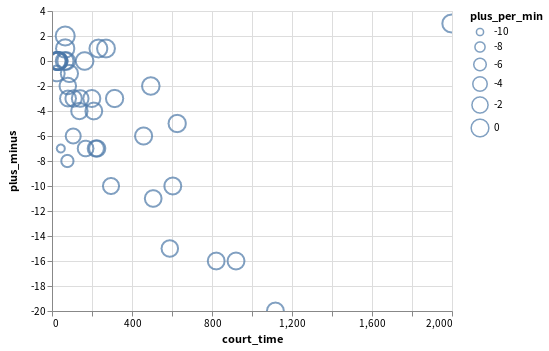

In [180]:
chart.encode(x = 'court_time', y="plus_minus", size='plus_per_min', tooltip= ['_id'])

In [176]:
from scipy import stats

In [170]:
df.loc[:, 'court_time'].values

array([  10.,   29.,   24.,  604.,   87., 1117.,  168.,  199.,  219.,
         23.,   30.,   63.,   44.,   79.,  313.,   80.,  494.,  920.,
        506.,   66.,  458.,  106.,   77.,  141., 1996.,  226.,  232.,
         33.,   34.,  295.,   26.,  108.,  163.,  137.,  626.,  209.,
        589.,   71.,  270.,  821.,   66.])

In [171]:
stats.linregress(df.loc[:, 'court_time'].values, df.loc[:, 'plus_minus'].values)

LinregressResult(slope=-0.005791181820471408, intercept=-2.5829632432457736, rvalue=-0.4073231150450561, pvalue=0.00821270412585841, stderr=0.002079226231766544)